# V2 version <br>
## compare to V1: <br>
  &nbsp; * &nbsp; change image size to 64 64 3 (256 256 3 in v1) <br>
  &nbsp; * &nbsp; reduce layers from discriminator  <br>
    # x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2))(x) <br>
    # x = layers.Dropout(0.2)(x)<br>
  &nbsp; * &nbsp; reduce layers from generator  <br>
    # x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x) <br>
    # x = layers.BatchNormalization(momentum = 0.7)(x)<br>
  &nbsp; * &nbsp; Added image sampling
  &nbsp; * &nbsp; Added math import
  &nbsp; * &nbsp; Param change:
    # ALTERNATOR  3 -> 2
    # EPOCH 200 -> 500
    # LATENT_DIM 100 -> 20
    # BATCH_SIZE 128 -> 250
  &nbsp; * &nbsp; Added Dropout Layers in generator

  

In [1]:
## Imports
# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
# others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from glob import glob
import os
import time
import math

In [2]:
## variables
IMG_SIZE = (64,64,3)
EPOCH = 500
LATENT_DIM = 20
BATCH_SIZE = 250
EPOCH_SIZE = 50000 # how many imgs in each epoch 
SEED_SIZE = 16 # how many pictures to track progress of (must be perfect square for sample_image())
ALTERNATOR = 2 # times generator gets trained | each time discriminator gets trained

# path 
img_path = "./DCGAN"
data_path = "./data.npy"
output_img_dir="/content/drive/MyDrive/DCGAN_img"


In [3]:
# global variable: IMG_SIZE
def process_images(in_path, out_path):
  input_dir_error = not os.path.isdir(in_path)
  output_file_exist = os.path.isfile(out_path)

  if output_file_exist:
    print("Output file already exists, loading...")
    dataset = np.load(out_path)
  elif input_dir_error:
    print("Error: input path error")
    return None

  else:  
    image_files = glob(in_path + '/*.jpg')
    # main loop
    i = 0
    dataset = []
    for img in image_files:
      new_img = image.load_img(img)
      new_img = np.asarray(new_img)
      new_img = tf.image.resize(new_img, [IMG_SIZE[0],IMG_SIZE[1]])
      dataset.append(new_img)
      # track progress
      i += 1
      if i%100 == 0:
        print("Pictures processed: ", i)
    # scale and save
    dataset = np.array(dataset)
    dataset = dataset / 255 * 2 - 1
    np.save(out_path, dataset)
    print(f'Coverted {len(image_files)} images')

  print("data preparation finish")
  return dataset

In [4]:
# global variable: output_img_dir, SEED_SIZE
def sample_images(epoch, seeds):
  generated_image = generator(seeds, training=False)
  generated_image = generated_image / 2 + 0.5


  edge_size = int(math.sqrt(SEED_SIZE))
  fig, axs = plt.subplots(edge_size, edge_size)
  idx = 0
  for i in range(edge_size):
    for j in range(edge_size):
      axs[i,j].imshow(generated_image[idx])
      axs[i,j].axis('off')
      idx += 1
  fig.savefig(f"{output_img_dir}/{epoch}.jpg")
  plt.close()

  print(f"{output_img_dir}/{epoch}.jpg saved")

In [5]:
# process_images and load data
prepared_data = process_images(img_path, data_path) # used for creating training/testing set
data_shape = prepared_data.shape
print(f'shape of the data is {data_shape}')

data_train = tf.data.Dataset.from_tensor_slices(prepared_data).shuffle(EPOCH_SIZE).batch(BATCH_SIZE)
del prepared_data

Output file already exists, loading...
data preparation finish
shape of the data is (5000, 64, 64, 3)


In [6]:
# global variable: LATENT_DIM, IMG_SIZE
def create_generator():
  i = layers.Input(shape=(LATENT_DIM,))
  x = layers.Dense(2*2*128, use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(i)
  x = layers.Reshape((2, 2, 128))(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 4, 4, 128
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 8, 8, 64
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 16, 16, 32
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha = 0.2))(x)
  # 32, 32, 16
  x = layers.BatchNormalization(momentum = 0.7)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2DTranspose(IMG_SIZE[2], (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
  # 64, 64, 3, matching IMG_SIZE

  model = Model(i, x)
  return model
  

In [7]:
# global variable: IMG_SIZE
def create_discriminator():
  i = layers.Input(shape=IMG_SIZE)
  x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha=0.2))(i)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha=0.2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation=layers.LeakyReLU(alpha=0.2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  
  model = Model(i, x)
  return model

In [8]:
## Setting up models and define loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake):
  loss_real = cross_entropy(tf.ones_like(real), real)
  loss_fake = cross_entropy(tf.zeros_like(fake), fake)
  loss_total = loss_real + loss_fake
  return loss_total

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

generator_optimizer = Adam(0.0001, 0.5)
discriminator_optimizer = Adam(0.0001, 0.5)

generator = create_generator()
discriminator = create_discriminator()

In [9]:
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_both(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

  grad_disc = disc_tape.gradient(loss_disc, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

  return loss_gen, loss_disc

In [10]:
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_gen_only(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
  
  return loss_gen, loss_disc

In [11]:
# global variable: EPOCH, SEED_SIZE, LATENT_DIM
def train(dataset):
  seed = tf.random.normal([SEED_SIZE, LATENT_DIM])

  for i in range(1, EPOCH+1):
    start = time.time() # for testing
    loss_list_gen = []
    loss_list_disc = []

    j = 0 # alternate to train discriminator every other step
    for batch in dataset:
      if j == 0:
        loss_gen, loss_disc = train_both(batch)
      else:
        loss_gen, loss_disc = train_gen_only(batch)
      j = (j + 1) % ALTERNATOR

      loss_list_gen.append(loss_gen)
      loss_list_disc.append(loss_disc)
    
    epoch_loss_gen = sum(loss_list_gen) / len(loss_list_gen)
    epoch_loss_disc = sum(loss_list_disc) / len(loss_list_disc)

    if i % 10 == 0:
      sample_images(i, seed)

    print(f'Epoch {i}: Time Spent ({time.time()-start}), gen loss ({epoch_loss_gen}), disc loss ({epoch_loss_disc})' ) # for testing

In [12]:
# RUN TRAINING
train(data_train)

Epoch 1: Time Spent (5.729199171066284), gen loss (0.6669057607650757), disc loss (1.1797635555267334)
Epoch 2: Time Spent (1.5549147129058838), gen loss (0.6360827684402466), disc loss (0.9964998364448547)
Epoch 3: Time Spent (1.4792733192443848), gen loss (0.7457468509674072), disc loss (0.7646204829216003)
Epoch 4: Time Spent (1.4812371730804443), gen loss (0.5565306544303894), disc loss (0.9932371377944946)
Epoch 5: Time Spent (1.4693620204925537), gen loss (0.8710063099861145), disc loss (0.663537323474884)
Epoch 6: Time Spent (1.4717416763305664), gen loss (0.5987834930419922), disc loss (0.8408295512199402)
Epoch 7: Time Spent (1.4697682857513428), gen loss (0.7231367826461792), disc loss (0.7929273843765259)
Epoch 8: Time Spent (1.4835562705993652), gen loss (0.7500067949295044), disc loss (0.6968852877616882)
Epoch 9: Time Spent (1.4921460151672363), gen loss (0.67469722032547), disc loss (0.7435248494148254)
/content/drive/MyDrive/DCGAN_img/10.jpg saved
Epoch 10: Time Spent (

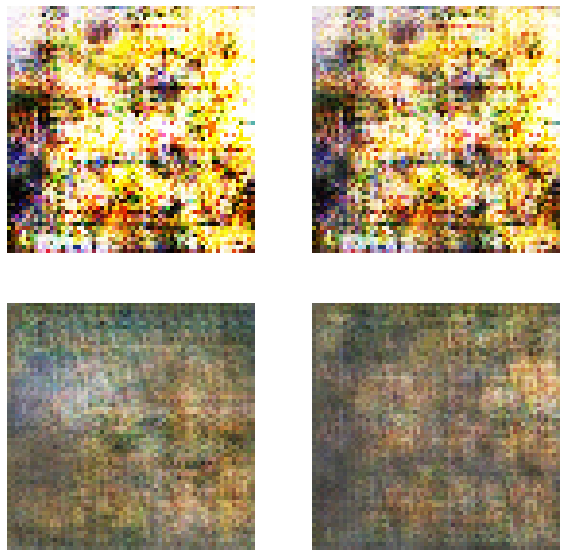

In [13]:
# see result
noise = tf.random.normal([4,LATENT_DIM])
generated_image = generator(noise, training=False)
generated_image = generated_image / 2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(generated_image.shape[0]):
  plt.subplot(2,2, i+1)
  plt.imshow(generated_image[i])
  plt.axis('off')
plt.show()


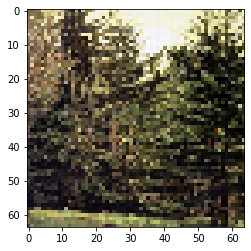

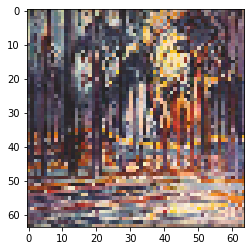

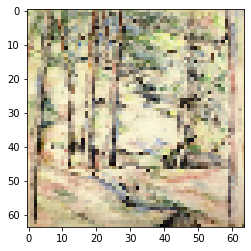

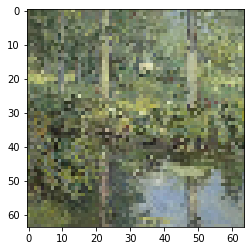

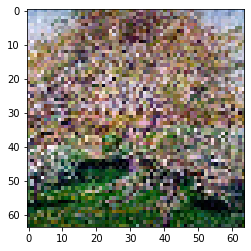

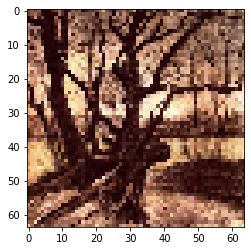

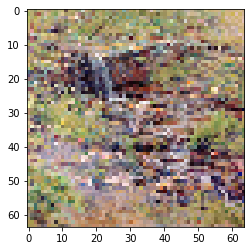

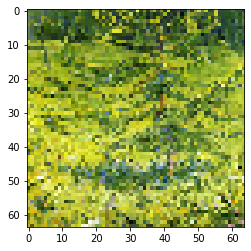

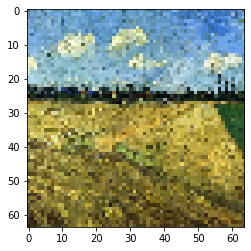

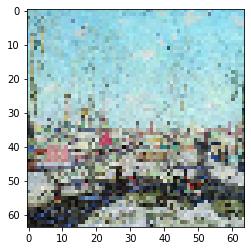

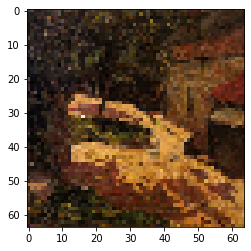

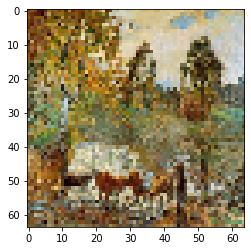

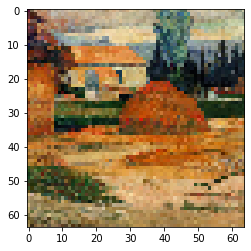

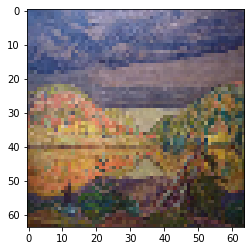

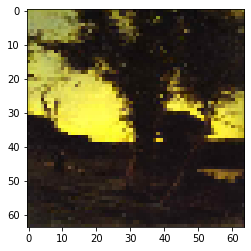

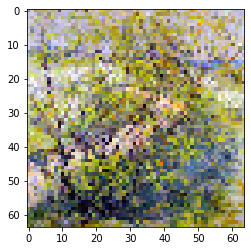

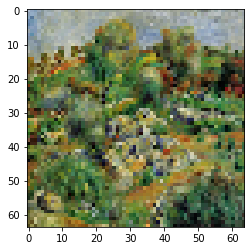

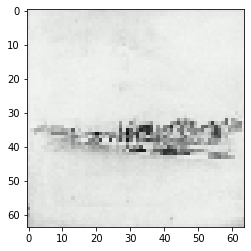

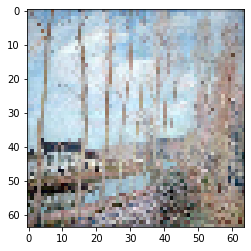

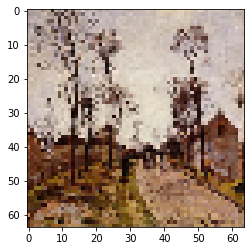

In [14]:
# print(generated_image[0])
# print(generated_image[1])
for batch in data_train:
  random_img = batch[0] / 2 + 0.5
  plt.imshow(random_img)
  plt.show()

(5000, 64, 64, 3)


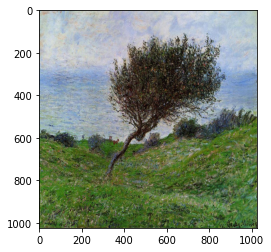

In [15]:
# test image
image_test = glob(img_path + '/*.jpg')
# resize_test = glob(resize_img_path + '/*.jpg')

print(data_shape)

random_img = image.load_img(np.random.choice(image_test))
plt.imshow(random_img)
plt.show()

# random_img = prepared_data[np.random.choice(data_shape[0])]
# random_img = random_img / 2 + 0.5
# plt.imshow(random_img)
# plt.show()

In [16]:
# !unrar x -r "/content/drive/MyDrive/DCGAN.rar" "/content/"